In [0]:
!mkdir images

In [2]:
%matplotlib inline

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd

print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
(x_train, y_train), (test_images, _) = tf.keras.datasets.cifar10.load_data()

print(x_train.shape)
print(test_images.shape)

170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [0]:
horse = np.zeros(shape=(5000,32,32,3))
j = 0
for i in range(len(y_train)):
    if y_train[i][0]==7:
        horse[j] = x_train[i]
        j += 1

In [0]:
train_images = horse

In [0]:
TRAIN_BUF=5000
BATCH_SIZE=64
TEST_BUF=10000
DIMS = (32,32,3)
N_TRAIN_BATCHES = int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [8]:
train_images[10][0][0]

array([39., 50., 25.])

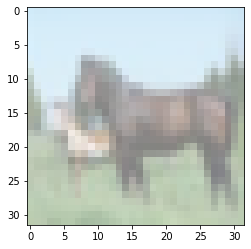

In [9]:
plt.imshow((train_images[2] + 255.) / 510.)

In [0]:
# normalizing dataset
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

In [11]:
train_images[10][0][0]

array([0.15294118, 0.19607843, 0.09803922], dtype=float32)

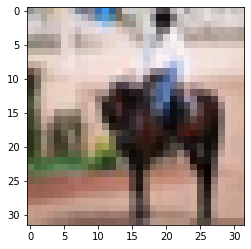

In [12]:
plt.imshow(train_images[1])
plt.show()

In [0]:
class WGAN(tf.keras.Model):
    """
    Extends tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(WGAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss_discriminator(self, x, z):
        z_samp = z  
        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)

        # gradient penalty
        d_regularizer = self.gradient_penalty(x, x_gen)
        ### losses
        disc_loss = (
            tf.reduce_mean(logits_x_gen) 
            - tf.reduce_mean(logits_x)
            + d_regularizer * self.gradient_penalty_weight
        )
        
        return disc_loss
      
    def compute_loss_generator(self, x, z):
        z_samp = z 
        x_gen = self.generate(z_samp)
        logits_x_gen = self.discriminate(x_gen)
        # losses of fake with label "1"
        gen_loss = -tf.reduce_mean(logits_x_gen)
        
        return gen_loss

    def compute_gradients_discriminator(self, x, z):
        
        with tf.GradientTape() as disc_tape:
            disc_loss = self.compute_loss_discriminator(x, z)

        # compute gradients
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return disc_gradients
      
    def compute_gradients_generator(self, x, z):
        
        with tf.GradientTape() as gen_tape:
            gen_loss = self.compute_loss_generator(x, z)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)

        return gen_gradients
      
      

    def apply_gradients_discriminator(self, disc_gradients):
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )
        
    def apply_gradients_generator(self, gen_gradients):
        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
        
        
    def gradient_penalty(self, x, x_gen):
        epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
        x_hat = epsilon * x + (1 - epsilon) * x_gen
        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = self.discriminate(x_hat)
        gradients = t.gradient(d_hat, x_hat)
        ddx = tf.sqrt(1e-8 + tf.reduce_sum(gradients ** 2, axis=[1, 2]))
        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
        return d_regularizer

      
    @tf.function
    def train(self, train_x):
      
      z = tf.random.normal([train_x.shape[0], self.n_Z])
      for _ in range(self.n_critic):
        disc_gradients = self.compute_gradients_discriminator(train_x, z)
        self.apply_gradients_discriminator(disc_gradients)
      
      
      gen_gradients = self.compute_gradients_generator(train_x, z)
      self.apply_gradients_generator(gen_gradients)
   


    def sample_images(self, epoch):

        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.n_Z))
        
        gen_imgs = self.generate(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(
                    gen_imgs[cnt], cmap=plt.cm.Greys, vmin=0, vmax=1
                )
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/img_%d.png" % epoch)
        plt.close()

In [0]:
N_Z = 64

generator = [
    tf.keras.layers.InputLayer(input_shape=(N_Z)),
    # tf.keras.layers.InputLayer(input_shape=(N_Z,1,1,)),
    # tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=4 * 4 * 4 * N_Z),
    tf.keras.layers.Reshape(target_shape=(4, 4, 4 * N_Z)), # (4, 4, 128) 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(activation='relu'),
    
    tf.keras.layers.Conv2DTranspose(filters=2*N_Z, kernel_size=2, strides=(2, 2)), # (8,8,64)
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(activation='relu'),
    
    tf.keras.layers.Conv2DTranspose(filters=N_Z, kernel_size=2, strides=(2, 2)), # (16,16,32)
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(activation='relu'),
    
    tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=2, strides=(2, 2)), # (32,32,3)
    tf.keras.layers.Activation(activation='tanh')
]


discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS),  # (32,32,3)

    tf.keras.layers.Conv2D(filters=N_Z, kernel_size=3, strides=(2, 2), padding="SAME"), # (16,16,32)
    tf.keras.layers.LeakyReLU(alpha=0.01), # 0.01 torch / 0.2 tensorflow
    
    tf.keras.layers.Conv2D(filters=2*N_Z, kernel_size=3, strides=(2, 2), padding="SAME"), # (8,8,64)
    tf.keras.layers.LeakyReLU(alpha=0.01),
    
    tf.keras.layers.Conv2D(filters=4*N_Z, kernel_size=3, strides=(2, 2), padding="SAME"), # (4,4,128)
    tf.keras.layers.LeakyReLU(alpha=0.01),
 
    tf.keras.layers.Flatten(), #(4*4*128)
    # tf.keras.layers.Dense(units=1, activation="sigmoid") 
    tf.keras.layers.Dense(units=1) 
]

In [0]:
gen_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9) # learning_rate = alpha = 0.0001
disc_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9)



model = WGAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    n_Z = N_Z,
    gradient_penalty_weight = 10.0,
    n_critic = 5
)

In [16]:
model.disc.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 4, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)             

In [17]:
model.gen.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              266240    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 256)         1024      
_________________________________________________________________
activation (Activation)      (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         131200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 128)         0

In [0]:
# exampled data for plotting results
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.generate(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
    samples = samples * 0.5 + 0.5
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].imshow(
                    samples[axi], vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

In [0]:
# model.load_weights('/content/weights.h5')

In [0]:
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

In [0]:
# losses = pd.read_csv('/content/loss.csv')

In [24]:
n_epochs = 400
total = 0

for i in range(n_epochs):
    epoch = i
  
    loss = []
     
    start = time.time()
    for train_x in train_dataset:
        model.train(train_x)
        
        z_samp = tf.random.normal([train_x.shape[0], model.n_Z]) 
        loss.append([model.compute_loss_discriminator(train_x, z_samp), model.compute_loss_generator(train_x, z_samp)])
    end = time.time()
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    
    total += (end - start)

    print('_______________________________________________________')
    print("Epoch {0} train time : {1:.2f} seconds".format(epoch, end-start))
    print(
        "Epoch: {0} | disc_loss: {1:.3f} | gen_loss: {2:.3f}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    
    if (epoch) % 20 == 0:
        model.sample_images(epoch + 200)

print("Total Training Time : {0:.2f} seconds".format(total))

_______________________________________________________
Epoch 0 train time : 6.80 seconds
Epoch: 0 | disc_loss: -2.698 | gen_loss: 8.812
_______________________________________________________
Epoch 1 train time : 6.71 seconds
Epoch: 1 | disc_loss: -2.592 | gen_loss: 8.863
_______________________________________________________
Epoch 2 train time : 6.78 seconds
Epoch: 2 | disc_loss: -2.658 | gen_loss: 8.969
_______________________________________________________
Epoch 3 train time : 6.78 seconds
Epoch: 3 | disc_loss: -2.661 | gen_loss: 8.983
_______________________________________________________
Epoch 4 train time : 6.75 seconds
Epoch: 4 | disc_loss: -2.640 | gen_loss: 10.763
_______________________________________________________
Epoch 5 train time : 6.72 seconds
Epoch: 5 | disc_loss: -2.630 | gen_loss: 9.157
_______________________________________________________
Epoch 6 train time : 6.77 seconds
Epoch: 6 | disc_loss: -2.624 | gen_loss: 9.297
________________________________________

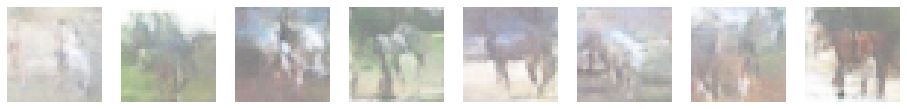

In [25]:
plot_reconstruction(model)

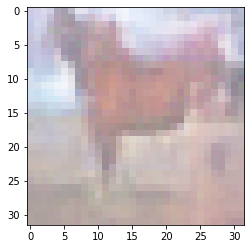

In [36]:
 z_samp = tf.random.normal([1, model.n_Z]) 
 img = model.gen(z_samp)
 plt.imshow(img[0] * 0.5 + 0.5)

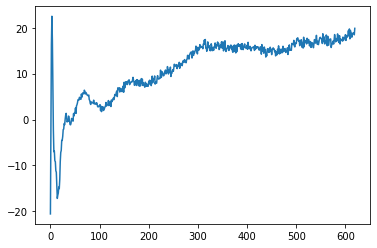

In [37]:
plt.plot(losses.gen_loss.values)
plt.show()

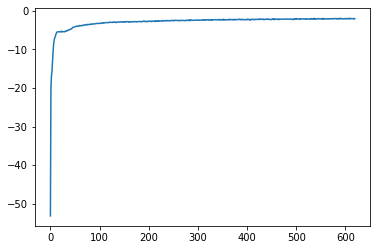

In [38]:
plt.plot(losses.disc_loss.values)
plt.show()

In [0]:
!zip -r /content/file.zip /content/images

In [0]:
losses.to_csv('loss.csv')

In [0]:
model.save_weights('weights.h5')